# TDI CAPSTONE PROJECT 

## Part 1 - Visualization

# TITLE: Share the road

### AUTHOR: Davide Cortesi

The data used in this notebook: https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95

## Importing Packages and Loading Data

In [3]:
# Importing Libraries 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')

# Plot packages
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

The data concerning accidents in NYC are loaded using the Socrata API and connecting to the NYC Open Database. Running the cell below might take a bit of time since we are paging the data.

In [ ]:
from sodapy import Socrata

# Loading Data

def load_data():
    client = Socrata('data.cityofnewyork.us', None)
    limit = 50000
    dim_check = limit
    offset = 0
    count = 1
    
    # first step
    results = client.get('h9gi-nx95', limit=limit, offset=offset)
    result_df = pd.DataFrame.from_records(results)
    print('Paging stage: ', count)
    
    while dim_check >= limit:
        # as long as the data are not finished (i.e. the reminder has
        # less observation than the data we scrape at each itearion)
        
        # store the new data in temp
        offset = count * limit 
        results = client.get("h9gi-nx95", limit=limit, offset=offset)
        temp_df = pd.DataFrame.from_records(results)
    
        # update the existing data
        dim_check = temp_df.shape[0]
        result_df = pd.concat([result_df, temp_df], ignore_index=True)
        count = count + 1
        print('Paging stage: ', count)

    result_df.sort_index(axis='index')
    return result_df

df_origin = load_data()


In [ ]:
df = df_origin.copy()
df.to_csv('data.csv')

Alternatively, we can load the data from the Data folder, in which a copy of the concerned dataset has been previously stored

In [2]:
df_origin = pd.read_csv('data.csv')
df = df_origin.copy()

/Users/programming/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (18) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Cleaning Some Missing Values

We begin exploring the data: we check for missing values and drop observations for which crucial features are missing (like the number of people involved in the accident, or the position of the accident)

In [3]:
def check_for_missing(df):
    missing = pd.concat([df.dtypes, df.isnull().sum(axis=0)], axis=1)
    missing.columns = ['type', 'missing values']
    return missing

check_for_missing(df)

,type,missing values
Unnamed: 0,int64,0
crash_date,object,0
crash_time,object,0
on_street_name,object,374247
number_of_persons_injured,float64,18
number_of_persons_killed,float64,31
number_of_pedestrians_injured,int64,0
number_of_pedestrians_killed,int64,0
number_of_cyclist_injured,int64,0
number_of_cyclist_killed,int64,0


In [4]:
# Deleting observations where both number_of_persons_killed and number_of_persons_injured are missing
cols = ['number_of_persons_killed', 'number_of_persons_injured']

mask = df[cols].isna().all(1)
print('Number of deleted obs: ', mask.sum())

df = df.dropna(subset=cols, how='all')
check_for_missing(df[cols]) 

Number of deleted obs:  12


,type,missing values
number_of_persons_killed,float64,19
number_of_persons_injured,float64,6


In [5]:
# Deleting observations where none of the following data are presents
cols = ['latitude', 'longitude', 'zip_code', 'borough', 'cross_street_name', 'on_street_name', 'off_street_name']

mask = df[cols].isna().all(1)
print('Number of deleted obs: ', mask.sum())

df = df.dropna(subset=cols, how='all')
df = df.drop('collision_id', axis=1)
check_for_missing(df[cols]) # A quick check

Number of deleted obs:  30026


,type,missing values
latitude,float64,186289
longitude,float64,186289
zip_code,object,536148
borough,object,535928
cross_street_name,object,1520867
on_street_name,object,344215
off_street_name,object,627732


## Feature engineering

Here we perform feature engineering. Some of these operations will be useful in the future, some others are not part of the workflow yet.

In [6]:
# Converting string type columns to int and float
cols_to_int = ['number_of_pedestrians_injured', 'number_of_pedestrians_killed', 'number_of_cyclist_injured', 
               'number_of_cyclist_killed', 'number_of_motorist_injured', 'number_of_motorist_killed']
cols_to_float = ['latitude', 'longitude', 'number_of_persons_injured', 'number_of_persons_killed']

def str_num_conv(df, cols_to_int, cols_to_float):
    for col in cols_to_int:
        df[col] = df[col].astype(int)
    for col in cols_to_float:
        df[col] = df[col].astype(float)
    return df

df = str_num_conv(df, cols_to_int, cols_to_float)

In [7]:
# Creating a single Date and Time columns
import datetime

def datetime_conversion(df):
    df['datetime'] = pd.to_datetime( df['crash_date'].apply(lambda x: x[:-12]) + df['crash_time'], 
                                    format='%Y-%m-%dT%H:%M')
    df = df.drop(['crash_date','crash_time'], axis=1)
    return df

df = datetime_conversion(df)

In [8]:
# Getting the number of vehicles from the data on the vehicles involved in the crash

def get_vehicle_number(df):
    df['number_of_vehicles'] = df[['vehicle_type_code1',
           'vehicle_type_code2',
           'vehicle_type_code_3',
           'vehicle_type_code_4',
           'vehicle_type_code_5']].notna().sum(axis=1)
    return df

df = get_vehicle_number(df)

# The columns regarding the vehicle type, although possibly very significant,
# are dropped, the data being very confused. 
# We could consider doing some encoding on them in some future projects.

cols = ['vehicle_type_code1', 'vehicle_type_code2', 'vehicle_type_code_3', 
        'vehicle_type_code_4', 'vehicle_type_code_5']
df = df.drop(labels=cols, axis=1)

In [9]:
# Encoding the factors contributing to the crash into (7+1) macro areas,
# each one providing a dummy variable

cat = []
labels = []

# Category: 'DRIVER_DISTRACTION'
cat.append(['Driver Inattention/Distraction', 'Cell Phone (hand-held)', 'Passenger Distraction',
         'Listening/Using Headphones', 'Texting', 'Cell Phone (hand-Held)', 'Cell Phone (hands-free)',
         'Using On Board Navigation Device', 'Eating or Drinking', 'Driver Inexperience',
         'Outside Car Distraction', 'Failure to Yield Right-of-Way', 'Traffic Control Disregarded', 
         'Other Electronic Device', 'Failure to Keep Right',
        ])
labels.append('driver_distraction')
# Category: 'INABILITY_TO_DRIVE'
cat.append(['Drugs (illegal)', 'Drugs (Illegal)', 'Alcohol Involvement', 'Illnes',
         'Illness', 'Fatigued/Drowsy', 'Fell Asleep', 'Prescription Medication', 'Lost Consciousness'
        ])
labels.append('inability_to_drive')
# Category: 'DANGEROUS_DRIVING'
cat.append(['Following Too Closely', 'Passing Too Closely', 'Passing or Lane Usage Improper', 'Turning Improperly', 
         'Unsafe Speed', 'Backing Unsafely', 'Unsafe Lane Changing', 'Aggressive Driving/Road Rage'
        ])
labels.append('dangerous_driving')
# Category: 'ROAD_CONDITION'
cat.append(['Pavement Slippery','Pavement Defective','Lane Marking Improper/Inadequate', 
         'Traffic Control Device Improper/Non-Working'
        ])
labels.append('road_condition')
# Category: 'VEHICLE_FAILURE'
cat.append(['Brakes Defective', 'Windshield Inadequate','Tow Hitch Defective', 'Headlights Defective',
         'Tire Failure/Inadequate','Other Lighting Defects','Steering Failure','Brakes Defective',
         'Accelerator Defective', 'Tinted Windows',
        ])
labels.append('vehicle_failure')
# Category: 'EXTERN_VEHICLE'
cat.append(['Reaction to Other Uninvolved Vehicle', 'Other Vehicular', 'Reaction to Uninvolved Vehicle', 
         'Driverless/Runaway Vehicle', 'View Obstructed/Limited', 'Obstruction/Debris',
        ])
labels.append('external_vehicle')
# Category: 'UNSPECIFIED'
cat.append(['Unspecified', 'UNSPECIFIED', 'unspecified'])
labels.append('unspecified')
# Category: 'OTHER'
cat.append(['Animals Action', 'Physical Disability', 'Glare'])
labels.append('other')

def format_cause(cause):
    label = ''
    for i in range(len(labels)):
        if cause in cat[i]:
            label = labels[i]
    return label

def cause_encoder(df):
    # columns to analyze
    cols = ['contributing_factor_vehicle_1','contributing_factor_vehicle_2','contributing_factor_vehicle_3',
       'contributing_factor_vehicle_4','contributing_factor_vehicle_5']
    for col in cols:
        df[col].fillna('UNSPECIFIED') # filling the NaN values before encoding
        df[col] = df[col].apply(format_cause) 
    df['causes'] = df['contributing_factor_vehicle_1'] + ' ' + df['contributing_factor_vehicle_2'] + '  ' + df['contributing_factor_vehicle_3'] + '  ' + df['contributing_factor_vehicle_4'] + '  ' + df['contributing_factor_vehicle_5']
    for label in labels:
        df['is_' + label] = 1 * (df['causes'].str.contains(label)) # multiplying by 1 to get an int column
    # dropping all the columns that are now unnecessary 
    # we drop also CAUSES (that is now resumed in the dummies) 
    # and IS UNSPECIFIED which gives no information
    df = df.drop(labels=cols, axis=1).drop(labels=['causes','is_unspecified'], axis=1)
    return df

df = cause_encoder(df)

## First observations

The graph below clearly shows a seasonality in data, especially when it comes to crashes involving pedestrian or cyclist. This makes sense given the strict dependence on the weather for this two way of moving. As a side note, we can also observe the down due to the lockdown, in the first part of 2020, coinciding with covid-19 outbreak.


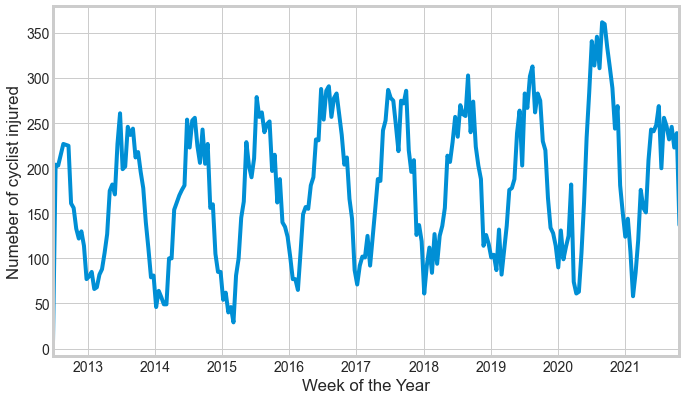

In [24]:
plt.figure(figsize=[10,6])

df['date'] = df['datetime']
df['week'] = df['datetime'].dt.week
df['year'] = df['datetime'].dt.year


df_viz = df

df_viz = df_viz.set_index('date')
df_viz['number_of_cyclist_injured'].resample('2W').sum().plot()
plt.xlabel('Week of the Year')
plt.ylabel('Numeber of cyclist injured');

In [26]:
fig = make_subplots(rows=4,cols=1,
                    subplot_titles=('Total', 'Pedestrian', 'Cyclist', 'Motorist'))

feat_injured  = ['number_of_persons_injured', 
                 'number_of_pedestrians_injured',
                 'number_of_cyclist_injured',
                 'number_of_motorist_injured']

feat_killed = ['number_of_persons_killed',
               'number_of_pedestrians_killed',
               'number_of_cyclist_killed',
               'number_of_motorist_killed']


for i in range(4):
    data_injured = df_viz[feat_injured[i]].resample('2W').sum()
    data_killed = df_viz[feat_killed[i]].resample('2W').sum()
    
    fig.add_trace(go.Scatter(x=data_injured.index, y=data_injured.values, name='Injured'), row=i+1,col=1)
    fig.add_trace(go.Scatter(x=data_killed.index, y=data_killed.values, name='Killed'), row=i+1, col=1)

fig.update_layout(title='Number of killed and injured',template='plotly_white', width=1000, height=1100)
fig.show()

## Focus on Cyclist
We focus our attention on crashes involving cyclists. We want to provide an indicator of the risk of a road/street/avenue. A possibility is to consider, for each road, a wighted combination of the following ratio

$$
	\frac{\text{# of death on the road}}{\text{total of death}} \qquad \frac{\text{# of injured on the road}}{\text{total of injured}} 
$$

We chose to penalize the death ration above of a factor 4 times  grater then the injured ratio (this is completely arbitrary).


In [34]:
# Selcting the interesting part of the DF

cols = ['on_street_name', 'zip_code' ,'number_of_cyclist_injured', 'number_of_cyclist_killed', 'latitude', 'longitude', 'datetime', 'cross_street_name', 'location', 'borough']
df_bike = df[(df['number_of_cyclist_injured'] > 0 ) | (df['number_of_cyclist_killed'] > 0)][cols]

df_bike.to_csv('data_bike.csv')

Text(0, 0.5, 'Street Name')

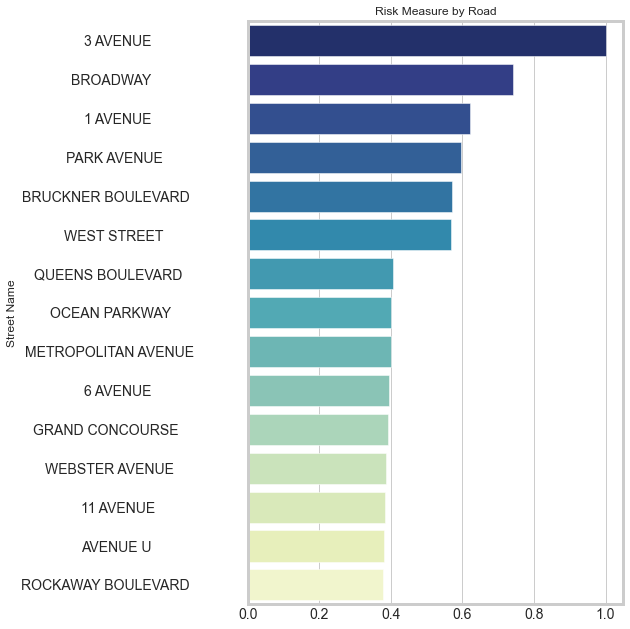

In [29]:
# Risk-measure computation

by_street = df_bike.groupby(by='on_street_name')

killed_by_street = (by_street['number_of_cyclist_killed'].sum())
killed_tot = killed_by_street.sum()

injured_by_street = (by_street['number_of_cyclist_injured'].sum())
injured_tot = injured_by_street.sum()


measure_by_street = 0.8 * (killed_by_street / killed_tot) + 0.2 * (injured_by_street / injured_tot)
from scipy.stats import zscore

measure_by_street = measure_by_street.sort_values(ascending=False)
measure_by_street = measure_by_street / measure_by_street.values[0]
top25 = measure_by_street[0:15]

plt.figure(figsize=(6,10))
plt.title('Risk Measure by Road', fontsize=12)

sns.barplot(y = top25.index, x = top25.values, palette='YlGnBu_r')
plt.ylabel('Street Name', fontsize=12)


## Plotting on a map

The cells belows nd the resulting graphs gives us some hints on the spatial distribution of the mosta dangerous (and safe) spot in the city.

In [4]:
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')
%matplotlib inline

import geopandas as gpd
ground_map = gpd.read_file('Maps/Boundaries/zip_boundaries.shp')

/Users/programming/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [6]:
df_bike = pd.read_csv('data_bike.csv')

df_bike = df_bike.dropna(subset=['latitude', 'longitude'], how='any')
df_bike['number_of_cyclist_involved'] = df_bike['number_of_cyclist_injured'] + df_bike['number_of_cyclist_killed']
gdf_bike = gpd.GeoDataFrame(df_bike, geometry=gpd.points_from_xy(df_bike.longitude, df_bike.latitude))

In [7]:
df_bike_zip = df_bike[['zip_code', 'number_of_cyclist_involved']].groupby(by='zip_code').sum()
df_bike_zip['zip_code'] = df_bike_zip.index.map(lambda x: int(x))
df_bike_zip.reset_index(drop=True, inplace=True)

In [8]:
shapefile = 'ZIP_CODE_040114/ZIP_CODE_040114.shp'
map_df = gpd.read_file(shapefile)
map_df['zip_code'] = map_df['ZIPCODE'].map(lambda x: int(x))

In [9]:
merged_df = pd.merge(left=map_df, right=df_bike_zip, how='left', left_on='zip_code', right_on='zip_code')
merged_df = merged_df[['zip_code', 'number_of_cyclist_involved', 'geometry']]

Text(0.5, 1.0, 'Bike crashes by zip_code')

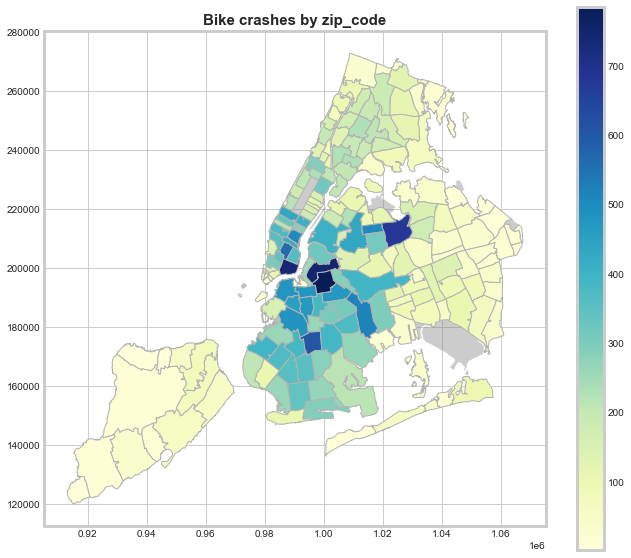

In [10]:
import matplotlib

my_cmap = matplotlib.cm.get_cmap('hot_r')

title = 'Number of person involved in accidents per ZIPCODE'
col = 'number_of_cyclist_involved'
fig, ax = plt.subplots(1, figsize=(10, 10))

map_df.plot(ax=ax, alpha=0.4, color='grey')

merged_df.plot(column=col, ax=ax, edgecolor='0.7', linewidth=1, legend=True, cmap='YlGnBu')

plt.title('Bike crashes by zip_code', fontsize=15, fontweight='bold')